In [83]:
# https://github.com/FluxML/model-zoo/blob/master/vision/vae_mnist/vae_mnist.jl

In [84]:
using MLDatasets, Flux, Plots,  Statistics

In [85]:
using Images
using Distributions:Normal , Bernoulli, logpdf
using Plots

In [86]:
struct Config2
    batch_size#  = 500
    lr # = 1e-3
    hidden_layer_dim # = 60
    latent_size 
    
end



In [87]:
c = Config2(500, 1e-3, 60,2)

Config2(500, 0.001, 60, 2)

In [88]:
train_x_2d, train_y = MNIST.traindata(Float32)
test_x_2d, test_y = MNIST.testdata(Float32)

([0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; … ;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0;;; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0; … ; 0.0 0.0 … 0.0 0.0; 0.0 0.0 … 0.0 0.0], [7, 2, 1, 0, 4, 1, 4, 9, 5, 9  …  7, 8, 9, 0, 1, 2, 3, 4, 5, 6])

In [89]:
size(train_x)

(784, 60000)

In [90]:
# ?reshape

In [91]:
train_x = reshape(train_x_2d, (28*28, :));
test_x = reshape(test_x_2d, (28*28, :));

6


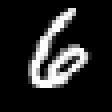

In [92]:
idx = 14
x1 = train_x_2d[:,:,idx];
y1 = train_y[idx]
println(y1)
colorview(Gray, x1', )

In [93]:
data_train =Flux.DataLoader((train_x, train_y), batchsize=c.batch_size, shuffle=true);
data_test =Flux.DataLoader((test_x, test_y), batchsize=c.batch_size, shuffle=true);

In [94]:
in_dims, _ = size(train_x)

(784, 60000)

In [95]:
h = c.hidden_layer_dim
latent_size = c.latent_size
# middle_dims =  4
activation = Flux.relu
encoder = Flux.Chain(
    Dense(in_dims, h, activation), 
    Dense(h,h, activation),
    Dense(h, latent_size*2,activation)

)

decoder = Flux.Chain(
    Dense(latent_size, h,activation), 
    Dense(h,h,activation),
    Dense(h, in_dims, Flux.σ)

)

Chain(
  Dense(2, 60, relu),                   # 180 parameters
  Dense(60, 60, relu),                  # 3_660 parameters
  Dense(60, 784, σ),                    # 47_824 parameters
)                   # Total: 6 arrays, 51_664 parameters, 202.188 KiB.

In [96]:
# https://github.com/adamwespiser/variational-autoencoders/blob/master/src/Model.jl
function split_encoder_result(X, n_latent::Int64)
  μ = X[1:n_latent, :]
  logσ = X[(n_latent + 1):(n_latent * 2), :]
  return μ, logσ
end

split_encoder_result (generic function with 1 method)

In [126]:
function reparameterize(μ :: T, logσ :: T) where {T}
  """
  reparameterize the results of 'encoder'
  onto a Normal(0,1) distribution,
  we could also pass "Float32" here instead, which would
  provide a uniform Distribution
  """
  return rand(Normal(0,1)) * exp.(logσ * 0.5f0) + μ
end

reparameterize (generic function with 1 method)

In [127]:

# function logp_x_z(x, z, f)
#   """
#   calculates log  P( X = x | Z = z ), reconstruction error
#   or: the conditional probability of data(digit image) given latent(z).
#   Our output is an image, but we are creating a distribution
#   using the sigmoid function to normalize decoder outputs
#   then passing it into a Bernoulli distribution.
#   logpdf(Distribution from decodor, image pixel) ...
#   => logpdf(Bernoulli(0.5f0),{0,1}) -> {-0.693, -0.693}
#   => summate over all of these values
#  """
#   return sum(logpdf.(Bernoulli.(sigmoid.(f(z))), x))
# end

In [128]:
function kl_q_p(μ :: T, logσ :: T) where {T}
  """"
  KL-divergence divergence, between approximate posterior/prior
  This is the KLD between a
  1) distribution of with means μ, variance logσ, and importanty, an
  identity covariance matrix, and
  2) A standard normal distribution Normal(μ = 0,σ = 1)
  """
  return 0.5f0 * sum(exp.(2f0 .* logσ) + μ.^2 .- 1 .- (2 .* logσ))
end

kl_q_p (generic function with 1 method)

In [129]:
# ?logpdf

In [200]:
function reconstruct(x)
    μ, log_σ = split_encoder_result(encoder(x),latent_size )
#     r1 = size(μ)
#     println("μ size is $(size(μ))   log_σ size is $(size(log_σ))")
    z = reparameterize(μ, log_σ)
    x_prime = decoder(z)
    return x_prime,  μ, log_σ 
end
function loss(x)
   # pass x through NN
   # compare mse of X and X_prime
    x_prime,  μ, log_σ  = reconstruct(x)
    
    len = size(x)[end]
    
    loss1 = sum((x-x_prime).^2)/len
    loss2 = kl_q_p(μ, log_σ)/len
    
    λ = 1e-4
    reg = λ * sum(x->sum(x.^2), Flux.params(decoder))
    
    return loss1+loss2+reg
end

loss (generic function with 1 method)

In [201]:
 opt = ADAM(1e-3)

ADAM(0.001, (0.9, 0.999), 1.0e-8, IdDict{Any, Any}())

In [202]:
ps = Flux.params(encoder, decoder);

In [203]:
epochs = 10
for epoch = 1:epochs
    @info "Epoch $(epoch)"
    flush(stdout)
    i = 0
    for (x,_) in data_train
        grads = Flux.gradient(ps) do
            l = loss(x)
        end
    #     Flux.train!(l, ps, data, opt)
    Flux.Optimise.update!(opt, ps, grads)
#     if i % 10 ==0
#         @info "i= $i"
#         flush(stdout)            
#     end
        
    i+=1
    end    
end

┌ Info: Epoch 1
└ @ Main In[203]:3
┌ Info: Epoch 2
└ @ Main In[203]:3
┌ Info: Epoch 3
└ @ Main In[203]:3
┌ Info: Epoch 4
└ @ Main In[203]:3
┌ Info: Epoch 5
└ @ Main In[203]:3
┌ Info: Epoch 6
└ @ Main In[203]:3
┌ Info: Epoch 7
└ @ Main In[203]:3
┌ Info: Epoch 8
└ @ Main In[203]:3
┌ Info: Epoch 9
└ @ Main In[203]:3
┌ Info: Epoch 10
└ @ Main In[203]:3


In [204]:
xstart, _ = first(data_train);

In [205]:
xstart_2d = reshape(xstart,  (28,28, :));

In [206]:
map(size, [xstart, xstart_2d])

2-element Vector{Tuple{Int64, Int64, Vararg{Int64}}}:
 (784, 500)
 (28, 28, 500)

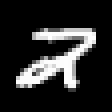

In [207]:
idx = 22
x1 = xstart_2d[:,:,idx];
# y1 = train_y[idx]
# println(y1)
colorview(Gray, x1', )

In [208]:
# xstart_1d_idx =
x_prime,  μ, log_σ  = reconstruct( xstart[:, idx]);

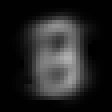

In [209]:
x_prime_2d = reshape(x_prime,  (28,28,));
colorview(Gray, x_prime_2d', )

In [210]:
size(x_prime_2d), size(x1)

((28, 28), (28, 28))

In [233]:
n = 10
idxs = 1:n
x1 = [xstart_2d[:,:,i] for i in idxs];
x11 = zeros(28,28*n)
for i in 1:n
size(x1)
    j = i-1
    idxs2 (j)
   x11[:, j*28+1:(j+1)*28+1]  = x1[i]
end
# x11 = vcat(x1);
# size(x1), size(x11)
# colorview(Gray, x11', )

LoadError: DimensionMismatch("tried to assign 28×28 array to 28×29 destination")

In [227]:
x1[1]

28×28 Matrix{Float32}:
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0       0.0       0.0       0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.470588  0.760784  0.172549  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.992157  0.992157  0.517647  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.992157  0.992157  0.745098  0.0
 0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.992157  0.807843  0.298039  0.0
 ⋮                        ⋮ 

In [211]:
?hcat

search: hcat hvcat hvncat MathConstants ∇depthwiseconv_data ∇depthwiseconv_data!



```
hcat(A...)
```

Concatenate along dimension 2.

# Examples

```jldoctest
julia> a = [1; 2; 3; 4; 5]
5-element Vector{Int64}:
 1
 2
 3
 4
 5

julia> b = [6 7; 8 9; 10 11; 12 13; 14 15]
5×2 Matrix{Int64}:
  6   7
  8   9
 10  11
 12  13
 14  15

julia> hcat(a,b)
5×3 Matrix{Int64}:
 1   6   7
 2   8   9
 3  10  11
 4  12  13
 5  14  15

julia> c = ([1; 2; 3], [4; 5; 6])
([1, 2, 3], [4, 5, 6])

julia> hcat(c...)
3×2 Matrix{Int64}:
 1  4
 2  5
 3  6

julia> x = Matrix(undef, 3, 0)  # x = [] would have created an Array{Any, 1}, but need an Array{Any, 2}
3×0 Matrix{Any}

julia> hcat(x, [1; 2; 3])
3×1 Matrix{Any}:
 1
 2
 3
```


In [149]:
# μ = rand(2,500)
# logσ= rand(2,500)
# # .exp(logσ * 0.5f0) 
# rand(Normal(0,1)) * exp.(logσ * 0.5f0) + μ


# exp.([1,2])

